#Packages

In [3]:
import numpy
from numpy.linalg import norm
from numpy import dot,array
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patches as patches
from pylab import show,imshow
import heapq
from math import *
import cvxopt
from cvxopt import matrix,solvers
import random
import time
import os
import matplotlib.animation as animation
import cv2
from IPython import display
from tqdm import tqdm

#Initialiser la géométrie

In [4]:
def draw(Ex, Obs, Obs_cir, scene, agents, t, savepath, play = False):
    
    L , l = scene
    ratio = l/L
    c = 10
    
    fig, ax = plt.subplots(figsize=(c/ratio,c))

    title = ax.text(0.5, 1.05, "Temps de simulation : %s s \n Nombre des agents : %s" %(t,len(agents)), 
                    transform=ax.transAxes, ha="center", size=20)

    #Draw the environment
    plt.plot([0, L], [0, 0], 'white')
    plt.plot([L, L], [0, l], 'white')
    plt.plot([L, 0], [l,l], 'white')
    plt.plot([0,0], [l,0], 'white')

    
    #Draw Obstacle
    for obs in Obs:
        rect = Rectangle(obs.position, obs.width, obs.height)
        rect.set_color('black')
        ax.add_patch(rect)

    #Draw Obstacle Cir
    for obs in Obs_cir:
        circle = Circle(obs.position, obs.rayon)
        circle.set_color('black')
        ax.add_patch(circle)
    
    #Draw exits
    for e in Ex:
        rect = Rectangle(e.position, e.width, e.height)
        rect.set_color('orange')
        ax.add_patch(rect)

    #Draw agents
    for agent in agents:
        x,y = agent.position
        circle = Circle((x,y), agent.size)
        circle.set_color(agent.color)
        ax.add_patch(circle)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    fig.savefig(savepath)

    if not play:
        plt.close()

In [5]:
def record_video(speed = 25):
    print('Recording video ...')
    frame = cv2.imread('DossierImages/simulation' + str(10) + '.jpg')
    height, width, layers = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter('video.avi', fourcc, speed, (width,height))

    for k in range(N_iter):
        video.write(cv2.imread('DossierImages/simulation' + str(k+1) + '.jpg'))

    cv2.destroyAllWindows()
    video.release()
    print('Video saved.')

In [38]:

def rand_float_range(start, end):
    return random.random() * (end - start) + start
rand_float_range(int(0),int(a))

2.1130725739329326

In [7]:
def generate_indiv(N):

    def rand_float_range(start, end):
        return random.random() * (end - start) + start

    a , b = size_scene
    dst = 0.2
    r = 0.2
    L = list()

    while len(L) < N:

        choc = False

        q = [agent.position for agent in L]
        R = [agent.size for agent in L]
    
        x = rand_float_range(int(0),int(a))
        y = rand_float_range(int(0),int(b))
    
        q.append([x,y])
        R.append(r)


        for j in range(len(q)-1):
            if dist(q[-1], q[j]) - (R[-1]+R[j]) <= dst:
                choc = True
                break
        
        #chocs obstacle
        for obstacle in obstacles_cir:
            [a0, b0], rayon = obstacle.position, obstacle.rayon
            if (x-a0)**2 + (y-b0)**2 < (rayon+3)**2 : choc = True
            
        for obstacle in obstacles:
            [a0, b0], w, l = obstacle.position, obstacle.width, obstacle.height
            a1, b1 = a0 + w , b0 + l

            if (a0<=x<=a1 and b0-r-0.5<=y<=b1+r+0.5) or (b0<=y<=b1 and a0-r-0.5<=x<=a1+r+0.5): choc = True
            elif distance_vecteur_obs([x,y] , r, obstacle)[0] < 0.5: choc = True

        if not choc:
            agent = myAgent((x,y))
            agent.size = r
            L.append(agent)

    return L

In [8]:
def maxiMini(FX,FY):
  maxi = 0
  Mini = 0
  for i in range(n):
    for j in range(len(FX[0])):
      fx , fy = FX[i][j] , FY[i][j]
      if fx != float('inf') and fx != -float('inf') and fy != float('inf') and fy != -float('inf') and not isnan(fx) and not isnan(fy):
        if fx>maxi :
          maxi = fx
        if fy>maxi :
          maxi = fy
        if fx<Mini : 
          Mini = fx
        if fy<Mini :
          Mini = fy

  return maxi , Mini

def plot_directions(FX,FY):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
  Z = [FX, FY]
  text = ['Directions selon X', 'Directions selon Y']
  maxi , Mini = maxiMini(FX,FY)

  for ax, i in zip(axes.flat, range(2)):
      im = ax.imshow(Z[i], interpolation="bicubic", origin="upper", vmin=Mini, vmax=maxi)
      ax.title.set_text(text[i])

  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
  fig.colorbar(im, cax=cbar_ax)

  plt.show()

In [9]:
class Exit:
  
    def __init__(self,position,width,height):

        self.position = position
        self.width = width
        self.height = height

In [10]:
class Obstacle():

    def __init__(self, position,width,height):

        self.position=position
        self.width=width
        self.height=height
        
    def __repr__(self):
        return 'Obstacle'+'\n'+'DL:'+str(self.position)+'DR:'+str((self.position[0]+self.width,self.position[1]))+'UR:'+str((self.position[0]+self.width,self.position[1]+self.height))+'UL:'+str((self.position[0]+self.width,self.position[1]))

In [11]:
class Obstacle_Cir():

    def __init__(self, position,rayon):
        self.position=position
        self.rayon=rayon

#Fast Marching

In [12]:
class PriorityQueue():


    def __init__(self):
        self.queue = []
        self.current = 0

    def pop(self):
        return heapq.heappop(self.queue)

    def remove(self, nodeId):
        for i in range(len(self.queue)):
            if self.queue[i][1]==nodeId:
                self.queue.pop(i)
                break;

    def __iter__(self):
        return self

    def __str__(self):
        return 'PQ:[%s]'%(', '.join([str(i) for i in self.queue]))

    def append(self, node):
        heapq.heappush(self.queue,node)

    def __contains__(self, key):
        self.current = 0
        return key in [n for _,n in self.queue]

    def __eq__(self, other):
        self.curent = 0
        return self == other

    def __getitem__(self, nodeId):
        for element in self.queue:
            if element[1]==nodeId:
                return element
        return None

    def clear(self):
        self.queue = []

    def __len__(self):
        return len(self.queue)

    __next__ = next

In [84]:
class GridGraph:

    global OBSTACLE
    global EXIT
    OBSTACLE = 0
    EXIT = 2

    def __init__(self,size_scene,precision):
        self.precision = precision
        self.horizontal_size = int(size_scene[0]*precision)+1
        self.vertical_size = int(size_scene[1]*precision)+1
        self.indicator_map = numpy.ones((self.vertical_size,self.horizontal_size))
        self.distances = numpy.ones((self.vertical_size,self.horizontal_size))*float('inf')

    def get_neighbours(self,node):
        result = {};
        if node[1]<self.horizontal_size-1:
            result['x+1']=(node[0],node[1]+1);
        if node[1]>0:
            result['x-1']=(node[0],node[1]-1);
        if node[0]<self.vertical_size-1:
            result['y+1']=(node[0]+1,node[1]);
        if node[0]>0:
            result['y-1']=(node[0]-1,node[1]);
        return result;

    def to_node(self,coordinates):
        return (int(coordinates[1]*self.precision),int(coordinates[0]*self.precision))

    def prepare_graph_for_fast_marching(self,obstacles, obstacles_cir, exits):
        for obstacle in obstacles:
            dl = (obstacle.position[0],obstacle.position[1])
            ur = (obstacle.position[0]+obstacle.width,obstacle.position[1]+obstacle.height)

            for x in range(self.to_node(dl)[0]+1,self.to_node(ur)[0]):
                for y in range(self.to_node(dl)[1]+1,self.to_node(ur)[1]):
                    if x>=0 and x<self.indicator_map.shape[0] and y>=0 and y<self.indicator_map.shape[1]:
                        self.indicator_map[x,y]=OBSTACLE

        for obstacle_cir in obstacles_cir:
            dl = (obstacle_cir.position[0] - obstacle_cir.rayon , obstacle_cir.position[1] - obstacle_cir.rayon)
            ur = (obstacle_cir.position[0] + obstacle_cir.rayon , obstacle_cir.position[1] + obstacle_cir.rayon)

            for x in range(self.to_node(dl)[0]+1,self.to_node(ur)[0]):
                for y in range(self.to_node(dl)[1]+1,self.to_node(ur)[1]):
                    if x>=0 and x<self.indicator_map.shape[0] and y>=0 and y<self.indicator_map.shape[1]:
                        if (x/self.precision - obstacle_cir.position[1])**2 + (y/self.precision - obstacle_cir.position[0])**2 <= obstacle_cir.rayon**2:
                            self.indicator_map[x,y]=OBSTACLE

        for exit_ in exits:
            dl = (exit_.position[0],exit_.position[1])
            ur = (exit_.position[0]+exit_.width,exit_.position[1]+exit_.height)
            for x in range(self.to_node(dl)[0],self.to_node(ur)[0]+1):
                for y in range(self.to_node(dl)[1],self.to_node(ur)[1]+1):
                    if x>=0 and x<self.indicator_map.shape[0] and y>=0 and y<self.indicator_map.shape[1]:
                        self.indicator_map[x,y]=EXIT

In [14]:
def fast_marching_method(graph,start):
    
    def calculus_distance(node,graph,weights):
        neighbours = graph.get_neighbours(node);
        if 'y-1' in neighbours :
            if 'y+1' in neighbours:
                x1 = min(weights[neighbours['y-1']],weights[neighbours['y+1']]);
            else :
                x1 = weights[neighbours['y-1']];
        else :
            if 'y+1' in neighbours:
                x1 = weights[neighbours['y+1']];
        if 'x-1' in neighbours:
            if 'x+1' in neighbours:
                x2 = min(weights[neighbours['x-1']],weights[neighbours['x+1']]);
            else :
                x2 = weights[neighbours['x-1']];
        else :
            if 'x+1' in neighbours:
                x2 = weights[neighbours['x+1']];
        
        if 2*h**2-(x1-x2)**2>=0:
            return (x1+x2+(2*h**2-(x1-x2)**2)**0.5)/2
        else:
            return min(x1,x2)+h
        
    
    frontier = PriorityQueue();
    weights = graph.distances;
    
    explored = []
    
    goals = numpy.where(graph.indicator_map==2)
    goals_x = goals[0]
    goals_y = goals[1]
    for i in range(goals_x.size):
        frontier.append([0,(goals_x[i],goals_y[i])])
        weights[(goals_x[i],goals_y[i])] = 0
    
       
    while frontier:
        node = frontier.pop();
        explored.append(node[1])
        #if node[1]==start:
        #   return weights
        neighbours = graph.get_neighbours(node[1]);
        for neighbour in neighbours.values():
            if neighbour not in explored and graph.indicator_map[neighbour]:
                if not neighbour in frontier:
                    frontier.append([calculus_distance(neighbour,graph,weights),neighbour])
                    weights[neighbour]=calculus_distance(neighbour,graph,weights)
                elif weights[neighbour] > calculus_distance(neighbour,graph,weights):
                    frontier[neighbour][0]=calculus_distance(neighbour,graph,weights)
                    weights[neighbour]=calculus_distance(neighbour,graph,weights)
    graph.distances = weights

In [15]:
def adjust_FM():

    Lx_gauche = []
    Lx_droite = []

    for i in range(1,n):
      for j in range(1,len(FX[0])-1):

        u , v = FX[i][j] , FX[i][j+1]

        if u == float('inf') or u == -float('inf'):
          if v != float('inf') and v != -float('inf') and not isnan(v):
            Lx_gauche.append((i,j))

        if v == float('inf') or v == -float('inf'):
          if u != float('inf') and u != -float('inf') and not isnan(u):
            Lx_droite.append((i,j+1))

    for cellule in Lx_gauche:
      i, j = cellule
      FX[i][j] = FX[i][j+1]

    for cellule in Lx_droite:
      i, j = cellule
      FX[i][j] = FX[i][j-1]

    Ly_haut = []
    Ly_bas = []

    for i in range(1,n-1):
      for j in range(1,len(FY[0])):

        u , v = FY[i][j] , FY[i+1][j]

        if u == float('inf') or u == -float('inf'):
          if v != float('inf') and v != -float('inf') and not isnan(v):
            Ly_haut.append((i,j))

        if v == float('inf') or v == -float('inf'):
          if u != float('inf') and u != -float('inf') and not isnan(u):
            Ly_bas.append((i+1,j))


    for cellule in Ly_haut:
      i, j = cellule
      FY[i][j] = FY[i+1][j]

    for cellule in Ly_bas:
      i, j = cellule
      FY[i][j] = FY[i-1][j]

#MyAgent

In [16]:
class myAgent():
    
    def __init__(self, position):
        self.position = numpy.array(position)
        self.speed = (0,0)
        self.D_S = (0,0)
        self.size = 0.2
        self.has_reached_exit = False
        self.near_to_exit = False
        self.masse = 80
        self.color = 'red'

    def desired_direction(self):
        x, y = self.position
        a, b = size_scene
        n , m = int(x/h) , int((b-y)/h)
        if n < 0 : n = 0
        if m < 0 : m = 0
        if n > len(FX[0])-1 : n = len(FX[0])-1
        if m > len(FX)-1 : m = len(FX)-1
        v = numpy.array((FX[m][n], FY[m][n]))
        if norm(v)==0: return numpy.array((0,0))
        return v / norm(v)

    def update_D_S(self):
        self.D_S = self.desired_direction()

    def update_Speed(self, v):
        self.speed = (v[0],v[1])

    def reach_exit(self):
        for ex in exits:
            d , _ = distance_vecteur_obs(self.position , self.size, ex)
            if d <= 0.2:
                self.has_reached_exit = True
                break

    def update_Position(self, q):
        self.position = q
        self.reach_exit()

#Fonctions

In [17]:
#force motrice
def f_motrice(agent):
    tau = 0.5
    return (numpy.array(agent.D_S)*2 - numpy.array(agent.speed))/tau

#force répulsive objet
def f_objet(agent):
    
    f = numpy.array([float(0),float(0)])

    for ag in agents:

        if ag != agent:

            d, n = matrice_distance[agents.index(agent)][agents.index(ag)] , matrice_normaux[agents.index(agent)][agents.index(ag)]
            f += alpha_obj * exp(-d/beta_obj) * n

    return f
    
#force répulsive obstacle
def f_obstacle(agent):
    
    f = numpy.array([float(0),float(0)])

    for obs in obstacles[4:]:
    
        [d, n] = distance_vecteur_obs(agent.position , agent.size, obs)
        f += alpha_obs * exp(-d/beta_obs) * n

    for obst in obstacles_cir:

        [d, n] = distance_vecteur_obs_cir(agent.position , agent.size, obst)
        f += alpha_obs * exp(-d/beta_obs) * n
      
    return f

In [18]:
def dist(p1,p2):
    return norm(numpy.array(p1)-numpy.array(p2))

def distance_vecteur_obj(q1, q2, r1, r2):
    d = dist(q1, q2)

    n = -(numpy.array(q2) - numpy.array(q1))/d

    d = d - (r1 + r2)

    return d , n

def distance_vecteur_obs_cir(q , r, obstacle):
    [a0, b0], rayon = obstacle.position, obstacle.rayon
    x , y = q
    
    d = ((x-a0)**2 + (y-b0)**2)**0.5 
    n = -(numpy.array(obstacle.position) - numpy.array(q))/d
    d = d - (rayon + r)

    return d , n

def distance_vecteur_obs(q , r, obstacle):
    [a0, b0], L, l = obstacle.position, obstacle.width, obstacle.height
    a1, b1 = a0 + L , b0 + l
    x , y = q
    point = []

    if x<=a0:
      if y>=b1:
        point = [a0, b1]

      elif b0<y<b1:
        point = [a0, y]

      else:
        point = [a0, b0]

    elif a0<x<a1:
      if y>=b1:
        point = [x, b1]

      elif b0<y<b1:
        point = [x, b1]

      else:
        point = [x, b0]

    else:
      if y>=b1:
        point = [a1, b1]

      elif b0<y<b1:
        point = [a1, y]

      else:
        point = [a1, b0]
        
    d = dist(point , q)
    n = (numpy.array(q) - numpy.array(point))/d

    return d - r , n

In [19]:
def matrice_normals(q, R):

    Normals = []
    agents_en_chocs = []
    m = len(q)

    #chocs agents
    for i in range(m):
        
        N = numpy.zeros(2*m)

        for j in range(m):
          if j != i:
            d , n = distance_vecteur_obj(q[i], q[j], R[i], R[j])
            if d <= 0.2:
              N[2*i], N[2*i+1], N[2*j], N[2*j+1] = n[0], n[1], -n[0], -n[1]

        if not all(v == 0 for v in N):
          Normals.append(N)
          agents_en_chocs.append(i)

    #chocs obstacle
    for obstacle in obstacles:
        
        N = numpy.zeros(2*m)

        for i in range(m):
          d , n = distance_vecteur_obs(q[i] , R[i], obstacle)
          if d <= 0.2:
            N[2*i], N[2*i+1] = n[0], n[1]
            if N[2*i] != 0 or N[2*i+1] != 0:
              agents_en_chocs.append(i)

        if not all(v == 0 for v in N):
          Normals.append(N)

    #chocs obstacle circulaire
    for obstacle in obstacles_cir:
        
        N = numpy.zeros(2*m)

        for i in range(m):
          d , n = distance_vecteur_obs_cir(q[i] , R[i], obstacle)
          if d <= .2:
            N[2*i], N[2*i+1] = n[0], n[1]
            if N[2*i] != 0 or N[2*i+1] != 0:
              agents_en_chocs.append(i)
    
        if not all(v == 0 for v in N):
          Normals.append(N)

    return numpy.array(Normals) , agents_en_chocs

In [20]:
def detection_de_chocs(Q, R):

  m = len(agents)

  for i in range(m):
    [x , y], r = Q[i], R[i]
    marge = .2

    #chocs obstacle
    for obstacle in obstacles:
        [a0, b0], L, l = obstacle.position, obstacle.width, obstacle.height
        a1, b1 = a0 + L , b0 + l
    
        if a0<=x<=a1 and b0-r-marge<=y<=b1+r+marge: return True
        if b0<=y<=b1 and a0-r-marge<=x<=a1+r+marge: return True

    for obst in obstacles_cir:
        [a0, b0], rayon = obst.position, obst.rayon
        d = ((x - a0)**2 + (y - b0)**2)**0.5
        if d - (rayon+r) < 2 : return True

    #chocs agents
    for j in range(m):
      if j != i:
        if dist(Q[i], Q[j]) - (R[i]+R[j]) <= marge: return True
  
  return False

In [21]:
def predict_position2(V):
  p = int(len(V)/2)
  V_future =  numpy.array([ numpy.array([V[2*j], V[2*j+1]]) for j in range(p) ])
  V_passe =   numpy.array([ numpy.array(agent.speed) for agent in agents ])
  
  return [numpy.array(agent.position) + dt*(V_future[agents.index(agent)] + V_passe[agents.index(agent)])/2 for agent in agents]

In [22]:
def correction_vitesses(V, Pext, K_n):
    V, Pext = numpy.array(V), numpy.array(Pext)
    p = len(agents)
    agents_en_chocs = []

    q = predict_position2(V)
    R = [agent.size for agent in agents]

    if detection_de_chocs(q, R):
        # Matrice Masse
        M = numpy.zeros((2*p, 2*p))
        for i in range(p):
            M[2*i][2*i] = agents[i].masse
            M[2*i+1][2*i+1] = agents[i].masse
    
        # Matrice Normales
        C_N , agents_en_chocs = matrice_normals(q, R)
    
        U = dot(C_N.transpose(), C_N)
        
        P = matrix(numpy.array(M) + 0.5 * K_n * U , tc='d')
        q = matrix(numpy.array(dot(M - 0.5 * K_n * U , V) + dt * Pext), tc='d')
        G = matrix(numpy.array(C_N), tc='d')
        h = matrix(numpy.array(numpy.zeros(len(C_N))), tc='d')
        
        solvers.options['show_progress'] = False
        
        return list(solvers.qp(P,-q,-G,h)['x']) , agents_en_chocs

    else:
        return V , agents_en_chocs

In [23]:
def matrice_DistancesEtNormaux(agents):
    N_ind = len(agents)
    matrice_distance = numpy.zeros((N_ind, N_ind))
    matrice_normaux = numpy.zeros((N_ind, N_ind,2))
    for i in range(N_ind):
        for j in range(N_ind):
            if i > j:
                d, n = distance_vecteur_obj(agents[i].position, agents[j].position, agents[i].size, agents[j].size)
                matrice_distance[i][j] = d
                matrice_distance[j][i] = d
                matrice_normaux[i][j] = n
                matrice_normaux[j][i] = -n
    return matrice_distance , matrice_normaux

def matrice_DistancesEtNormaux_danger(agents):
    N_ind = len(agents)
    matrice_distance = numpy.zeros(N_ind)
    matrice_normaux = numpy.zeros((N_ind, 2))
    for i in range(N_ind):
        d = dist(Dangers[0], agents[i].position)
        n = norm(numpy.array(Dangers[0]) - numpy.array(agents[i].position))
        matrice_distance[i] = d
        matrice_normaux[i] = n
    return matrice_distance , matrice_normaux

#Configuration

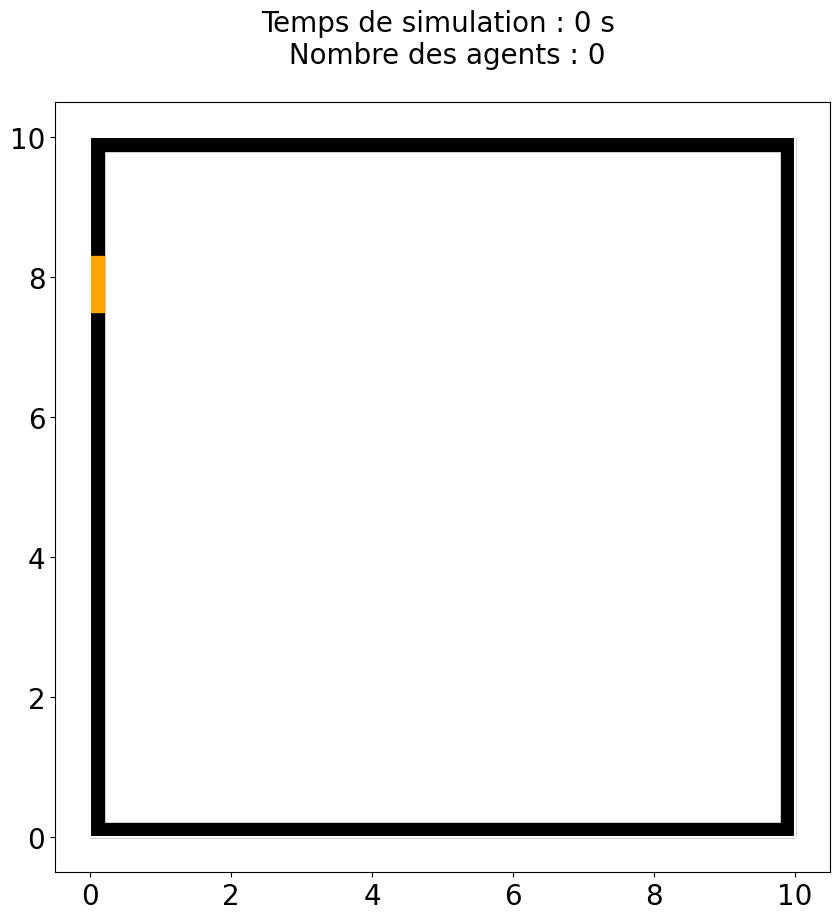

In [174]:
a , b , eps = 10 , 10 , 0.2
size_scene = (a,b)

obstacles = [Obstacle((0,0),a,eps), Obstacle((0,eps),eps,b-eps), Obstacle((eps,b-eps),a-eps,eps), Obstacle((a-eps, eps),eps, b-2*eps)]

exits = [Exit((0,7.5), eps, 4*eps)]

obstacles_cir = []

draw(exits, obstacles, obstacles_cir, size_scene, [], 0, 'gemoetrie.png', play=True)

#Champs de directions

In [175]:
h = .5 #pas de discritisation du FAst Marching

graph = GridGraph(size_scene,1/h)

graph.prepare_graph_for_fast_marching(obstacles, obstacles_cir, exits)

fast_marching_method(graph, (0,0))

In [176]:
d = graph.distances
d_tr = []
n = len(d)

for i in range(n):
    d_tr.append(d[n-i-1])

FY, FX = numpy.gradient(numpy.array(d_tr))

FX = -FX

adjust_FM()

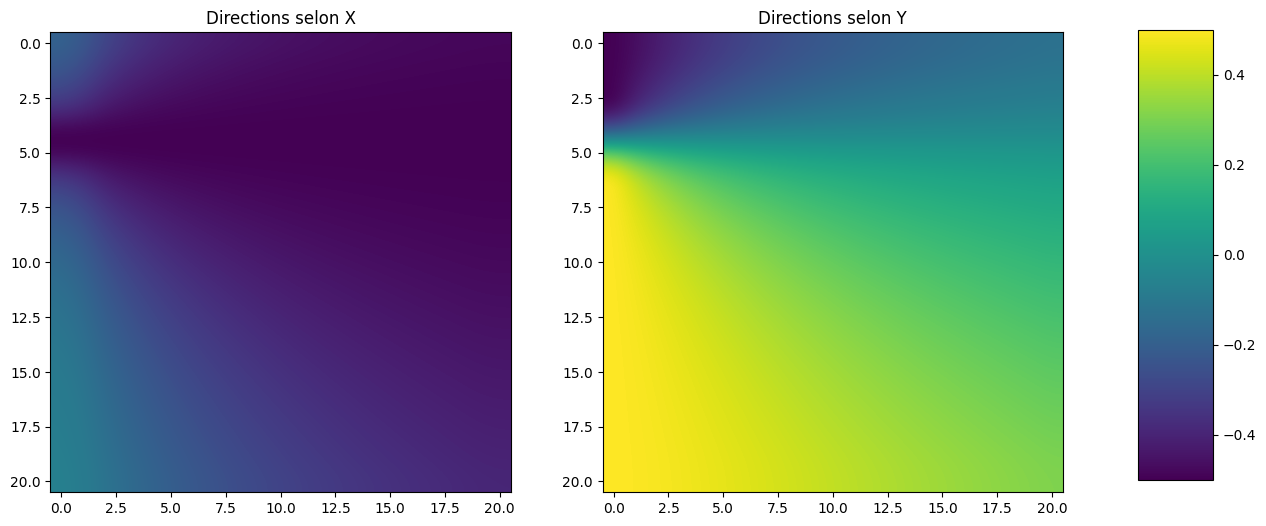

In [177]:
plot_directions(FX,FY)

#Simulation

In [178]:
def collect_individuals(data_path):
    dataframe=pd.read_csv(data_path)
    x_coordinates=list(dataframe.x_coordinate/2)
    y_coordinates=list(dataframe.y_coordinate/2)
    a , b = size_scene
    dst = 0.2
    r = 0.2
    L = list()
    for i in range(len(dataframe)):
        choc = False

        q = [agent.position for agent in L]
        R = [agent.size for agent in L]
    
        x = x_coordinates[i]
        y = b-y_coordinates[i]
        q.append([x,y])
        R.append(r)


        for j in range(len(q)-1):
            if dist(q[-1], q[j]) - (R[-1]+R[j]) <= dst:
                choc = True
                break
        
        #chocs obstacle
        for obstacle in obstacles_cir:
            [a0, b0], rayon = obstacle.position, obstacle.rayon
            if (x-a0)**2 + (y-b0)**2 < (rayon+3)**2 : choc = True
            
        for obstacle in obstacles:
            [a0, b0], w, l = obstacle.position, obstacle.width, obstacle.height
            a1, b1 = a0 + w , b0 + l

            if (a0<=x<=a1 and b0-r-0.5<=y<=b1+r+0.5) or (b0<=y<=b1 and a0-r-0.5<=x<=a1+r+0.5): choc = True
            elif distance_vecteur_obs([x,y] , r, obstacle)[0] < 0.5: choc = True
        choc=False
        if not choc:
            agent = myAgent((x,y))
            agent.size = r
            L.append(agent)
        

    return L

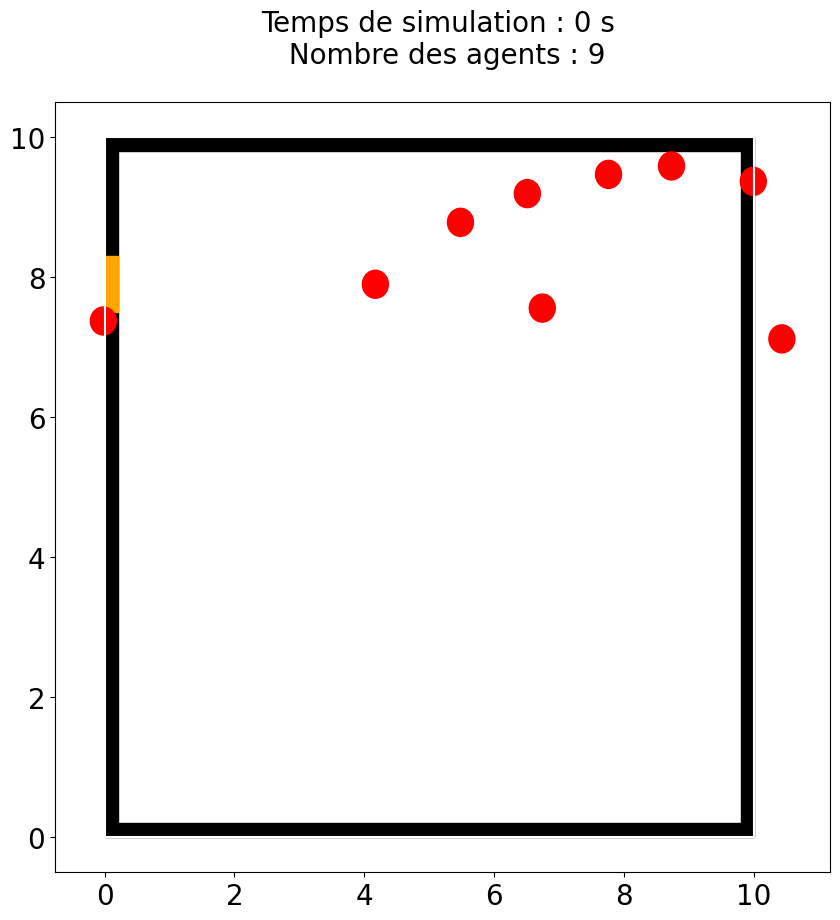

In [179]:
N_pop = 10
temps_de_sim = 1*60 #secondes
dt = 5e-2
N_iter = int(temps_de_sim / dt)
data_path='frame_data.csv'
agents = collect_individuals(data_path)

draw(exits, obstacles, obstacles_cir, size_scene, agents, 0, 'config_init.png', play=True)

In [180]:
K_n = 0

R = [agent.size for agent in agents]

!mkdir DossierImages
for image in os.listdir('DossierImages'):
    os.remove('DossierImages/' + image)

for n in tqdm(range(N_iter)):

    if len(agents)==0:break

    V_avant_correction = []
    P = []
    matrice_distance , matrice_normaux = matrice_DistancesEtNormaux(agents)

    for agent in agents:

        agent.update_D_S()
        p_ext = f_motrice(agent)
        vi = agent.speed + dt*p_ext/agent.masse
        V_avant_correction.extend(vi)
        P.extend(p_ext)
    
    V_new , agents_en_chocs = correction_vitesses(V_avant_correction, P, K_n)
    q = predict_position2(V_new)

    for agent in agents:
        k = agents.index(agent)
        agent.update_Speed([V_new[2*k] , V_new[2*k+1]])
        agent.update_Position(q[k])
        
    for agent in agents:
        if agent.has_reached_exit: agents.remove(agent)

    path = 'DossierImages/simulation' + str(n) + '.jpg'
    draw(exits, obstacles, obstacles_cir, size_scene, agents,round(n*dt, 2), savepath=path, play = False)
    
print('Simulation finished.')
record_video(speed = 25)

mkdir: impossible de créer le répertoire «DossierImages»: Le fichier existe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [04:20<00:00,  4.60it/s]


Simulation finished.
Recording video ...
Video saved.


[ WARN:0@9116.631] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('DossierImages/simulation1200.jpg'): can't open/read file: check file path/integrity


In [206]:
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_name='./data/simulation_video.avi'
height, width, layers = (1000, 1000, 3)
video = cv2.VideoWriter(video_name, fourcc, 40, (width, height))
for i in range(600):
    img = cv2.imread('./DossierImages/simulation{}.jpg'.format(i))
    video.write(img)
video.release()
print('video processed')
cv2.destroyAllWindows()

video processed
